In [43]:
# Import libraries 

import pandas as pd 
import numpy as np
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statsmodels.api as sm #i like statsmodels result table, lets me explore the coefficents more.
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lazypredict.Supervised import LazyClassifier

from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier

from imblearn.under_sampling import RandomUnderSampler 
from sklearn.feature_selection import SelectFromModel
from yellowbrick.model_selection import RFECV
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import KFold

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action = 'ignore', category = FutureWarning)

In [2]:
#load dataset 
td = pd.read_csv('term-deposit-marketing-2020.csv', header = 0)
td.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [3]:
td.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
age          40000 non-null int64
job          40000 non-null object
marital      40000 non-null object
education    40000 non-null object
default      40000 non-null object
balance      40000 non-null int64
housing      40000 non-null object
loan         40000 non-null object
contact      40000 non-null object
day          40000 non-null int64
month        40000 non-null object
duration     40000 non-null int64
campaign     40000 non-null int64
y            40000 non-null object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [4]:
# lets see if there are any null values 
td.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

Fortunatlly there are no missing values. 

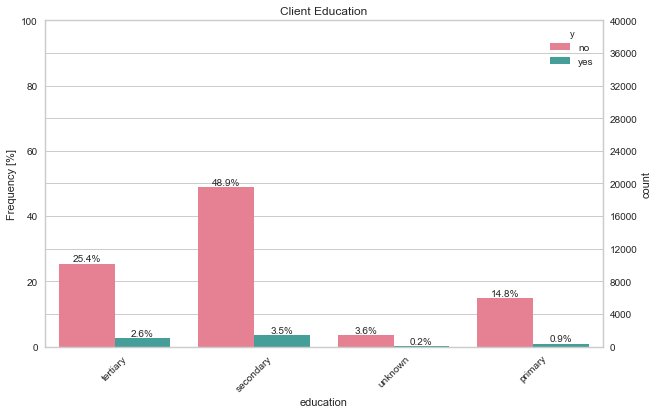

In [5]:
# Set up  matplotlib figure
f, ax = plt.subplots(figsize=(10, 6))

ax = sns.countplot(data = td, x = 'education', palette='husl', hue='y')
ncount = len(td)
ax2 = ax.twinx()
ax2.yaxis.tick_left()
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')
ax2.set_ylabel('Frequency [%]')
ax.set_ylabel('count')

ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

for p in ax.patches:
    x = p.get_bbox().get_points()[:,0]
    y = p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha = 'center', va = 'bottom') # set the alignment of the text

# Use a LinearLocator to ensure the correct number of ticks
ax.yaxis.set_major_locator(ticker.LinearLocator(11))

# Fix the frequency range to 0-100
ax2.set_ylim(0,100)
ax.set_ylim(0,ncount)
ax.set_title('Client Education')

# And use a MultipleLocator to ensure a tick spacing of 20
ax2.yaxis.set_major_locator(ticker.MultipleLocator(20))

# Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
ax2.grid(None)


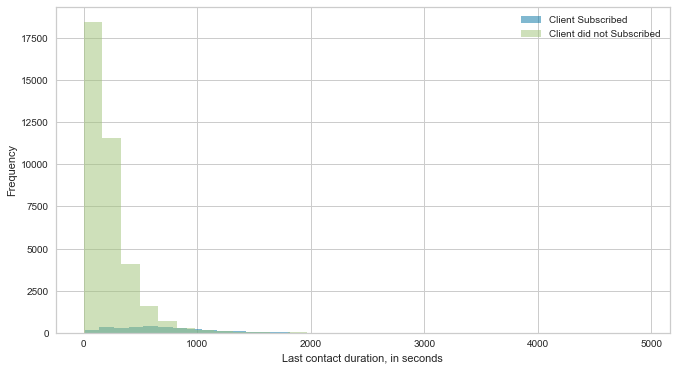

In [6]:
# check if there is any trend with last contact duration
subscribed = td.duration.loc[td.y == 'yes']
not_subscribed = td.duration.loc[td.y == 'no']

plt.figure(figsize = (11, 6))
_ = plt.hist(subscribed, bins = 30, alpha = 0.5, label='Client Subscribed')
_ = plt.hist(not_subscribed, bins=30, alpha=0.5, label='Client did not Subscribed')
_ = plt.xlabel('Last contact duration, in seconds')
_ = plt.ylabel('Frequency')
_ = plt.legend()


In [7]:
# It looks like feedback from custmers (features) is on 1-5 scale lets check
td.describe()

,age,balance,day,duration,campaign
count,40000.00,40000.00,40000.00,40000.00,40000.00
mean,40.54,1274.28,16.02,254.82,2.88
std,9.64,2903.77,8.28,259.37,3.24
min,19.00,-8019.00,1.00,0.00,1.00
25%,33.00,54.00,8.00,100.00,1.00
50%,39.00,407.00,17.00,175.00,2.00
75%,48.00,1319.00,21.00,313.00,3.00
max,95.00,102127.00,31.00,4918.00,63.00


In [8]:
'''Since the label of the data-set are given in terms of ‘yes’ and ‘no’, it’s necessary to replace them with numbers,
possibly with 1 and 0 respectively, so that they can be used in modelling of the data. In the first step we will convert 
the output labels of the data-set from binary strings of yes/no to integers 1/0.'''

td['y'] = (td['y'] == 'yes').astype(int)  # changing yes to 1 and no to 0
td['default'] = (td['default'] == 'yes').astype(int)  # changing yes to 1 and no to 0
td['loan'] = (td['loan'] == 'yes').astype(int)  # changing yes to 1 and no to 0
td['housing'] = (td['housing'] == 'yes').astype(int)  # changing yes to 1 and no to 0

td

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,261,1,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,151,1,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,76,1,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,92,1,0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,198,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,53,technician,married,tertiary,0,395,0,0,cellular,3,jun,107,1,0
39996,30,management,single,tertiary,0,3340,0,0,cellular,3,jun,238,3,1
39997,54,admin,divorced,secondary,0,200,0,0,cellular,3,jun,170,1,1
39998,34,management,married,tertiary,0,1047,0,0,cellular,3,jun,342,1,0


In [9]:
# lets change all the features to binary class using get_dummies
td = pd.get_dummies (td, columns = ['marital', 'education', 'contact', 'month','job'])
td

,age,default,balance,housing,loan,day,duration,campaign,y,marital_divorced,...,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown
0,58,0,2143,1,0,5,261,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1,44,0,29,1,0,5,151,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,33,0,2,1,1,5,76,1,0,0,...,1,0,0,0,0,0,0,0,0,0
3,47,0,1506,1,0,5,92,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,33,0,1,0,0,5,198,1,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,53,0,395,0,0,3,107,1,0,0,...,0,0,0,0,0,0,0,1,0,0
39996,30,0,3340,0,0,3,238,3,1,0,...,0,0,1,0,0,0,0,0,0,0
39997,54,0,200,0,0,3,170,1,1,1,...,0,0,0,0,0,0,0,0,0,0
39998,34,0,1047,0,0,3,342,1,0,0,...,0,0,1,0,0,0,0,0,0,0


This graph shows, there is an outlier with the duration data. I will need to check using box plot. 

## Semih Notes

+ Implement simple model
+ Feature engineering 
+ Fixing the data (outliers, missing value etc)
+ SHAP - interpretable machine learning 
+ building a complex model (as complex as it could overfit the data).

In [10]:
# First implement simple model 

# Create arrays for features and target variable
y = td['y'].values
x = td.drop(['y'], axis=1)


# Print the dimensions of X and y 
print("Dimensions of y before reshaping: {}".format(y.shape))
print("Dimensions of X before reshaping: {}".format(x.shape))

Dimensions of y before reshaping: (40000,)
Dimensions of X before reshaping: (40000, 41)


In [11]:
print (y)

[0 0 0 ... 1 0 0]


In [12]:
print(x)

       age  default  balance  housing  loan  day  duration  campaign  \
0       58        0     2143        1     0    5       261         1   
1       44        0       29        1     0    5       151         1   
2       33        0        2        1     1    5        76         1   
3       47        0     1506        1     0    5        92         1   
4       33        0        1        0     0    5       198         1   
...    ...      ...      ...      ...   ...  ...       ...       ...   
39995   53        0      395        0     0    3       107         1   
39996   30        0     3340        0     0    3       238         3   
39997   54        0      200        0     0    3       170         1   
39998   34        0     1047        0     0    3       342         1   
39999   38        0     1442        1     0    3       113         1   

       marital_divorced  marital_married  ...  job_entrepreneur  \
0                     0                1  ...                 0   
1

In [13]:
# Split the data into a training and test set.
x_train, x_test, y_train, y_test = train_test_split(x, y,random_state = 5, test_size = 0.2)

clf = LogisticRegression(solver='lbfgs')
# Fit the model on the trainng data.
clf.fit(x_train, y_train)

# Print the accuracy
print('Training Accuracy: {}'.format((accuracy_score(clf.predict(x_train), y_train))))
print('Testing Accuracy: {}'.format((accuracy_score(clf.predict(x_test), y_test))))

Training Accuracy: 0.93325
Testing Accuracy: 0.928625


In [14]:
x_train.shape

(32000, 41)

In [15]:
y_train.shape

(32000,)

In [16]:
td['y'].value_counts()

0    37104
1     2896
Name: y, dtype: int64

In [17]:
# Generate the confusion matrix and classification report

ypred = clf.predict(x_test)
# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, ypred))
print(classification_report(y_test, ypred))

[[7291   83]
 [ 488  138]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      7374
           1       0.62      0.22      0.33       626

    accuracy                           0.93      8000
   macro avg       0.78      0.60      0.64      8000
weighted avg       0.91      0.93      0.91      8000



## additional notes: 
- oversampling/ undersampling 
- find out how the data would do if you undersample the data 
- use the libarary imblearn (random undersampler) 
- feature enginering - use tree-based algorithm to see what particular features would add value to solve the problems (feature importance and coefficients). 
- measure the absolute effect feature. 

In [18]:
# First lets try how the model performs if we can randomly undersmaple the Class 0, to blance the data. 

rus = RandomUnderSampler(sampling_strategy = 'majority')
x_res, y_res = rus.fit_resample (x, y)
# summarize class distribution

print(Counter(y_res))

Counter({0: 2896, 1: 2896})


In [19]:
# Split the data into a training and test set.
x_res_train, x_res_test, y_res_train, y_res_test = train_test_split(x_res, y_res,random_state = 5, test_size = 0.2)

# Fit the model on the trainng data.
clf.fit(x_res_train, y_res_train)
y_res_pred = clf.predict(x_res_test)
# Generate the confusion matrix and classification report
print(confusion_matrix(y_res_test, y_res_pred))
print(classification_report(y_res_test, y_res_pred))

[[504  76]
 [143 436]]
              precision    recall  f1-score   support

           0       0.78      0.87      0.82       580
           1       0.85      0.75      0.80       579

    accuracy                           0.81      1159
   macro avg       0.82      0.81      0.81      1159
weighted avg       0.82      0.81      0.81      1159



In [20]:
x_res_train.shape

(4633, 41)

In [21]:
from imblearn.over_sampling import RandomOverSampler
# lets try how the model performs if we can randomly oversmaple the Class 1, to blance the data. 

ros = RandomOverSampler(sampling_strategy = 'minority')
x_ros, y_ros = ros.fit_resample (x, y)
# summarize class distribution

print(Counter(y_ros)) 


Counter({0: 37104, 1: 37104})


In [22]:
# Split the data into a training and test set.
x_ros_train, x_ros_test, y_ros_train, y_ros_test = train_test_split(x_ros, y_ros,random_state = 5, test_size = 0.2)

# Fit the model on the trainng data.
clf.fit(x_ros_train, y_ros_train)
y_ros_pred = clf.predict(x_ros_test)
# Generate the confusion matrix and classification report
print(confusion_matrix(y_ros_test, y_ros_pred))
print(classification_report(y_ros_test, y_ros_pred))

[[6263 1213]
 [1431 5935]]
              precision    recall  f1-score   support

           0       0.81      0.84      0.83      7476
           1       0.83      0.81      0.82      7366

    accuracy                           0.82     14842
   macro avg       0.82      0.82      0.82     14842
weighted avg       0.82      0.82      0.82     14842



### Feature Engineering 
Use tree-based algorithm to see what particular features would add value to solve the problems (feature importance and coefficients). How does Random forest select features?
Random forests consist of 4 –12 hundred decision trees, each of them built over a random extraction of the observations from the dataset and a random extraction of the features. Not every tree sees all the features or all the observations, and this guarantees that the trees are de-correlated and therefore less prone to over-fitting. Each tree is also a sequence of yes-no questions based on a single or combination of features. At each node (this is at each question), the three divides the dataset into 2 buckets, each of them hosting observations that are more similar among themselves and different from the ones in the other bucket. Therefore, the importance of each feature is derived from how “pure” each of the buckets is.

In [23]:
# feature enginering 

x_train, x_test, y_train, y_test = train_test_split(x,y, random_state = 42, test_size = 0.3)
fselect = SelectFromModel (RandomForestClassifier(n_estimators = 100)) # model fitting and feature selection in one line code
fselect.fit(x_train, y_train) # in feature selection procedures, its a good practice to select the features by examining only the training set to avoid overfitting. 

# To see which features are important we can sue get_support method on the fitted model

fselect.get_support()





array([ True, False,  True, False, False,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [24]:
fselect.get_support(indices = True)

array([0, 2, 5, 6, 7], dtype=int64)

In [25]:
# Make a list and count the selected features

x_train = pd.DataFrame(x_train)
selected_f = x_train.columns[(fselect.get_support())]
len(selected_f)



5

In [26]:
# Get the name of the selected features 
print(selected_f)

Index(['age', 'balance', 'day', 'duration', 'campaign'], dtype='object')


In [27]:
# Threshold used 

fselect.threshold_

0.02439024390243903

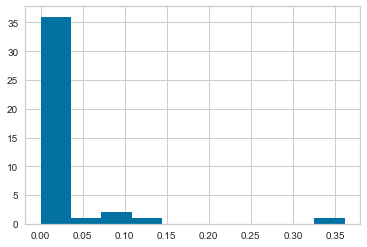

In [28]:
# plot distribution of feature importance 

pd.Series(fselect.estimator_.feature_importances_.ravel()).hist()

In [29]:
# model.transform (data) reduce the data to the selected features

x_sel = fselect.transform(x)
x_sel


array([[  58, 2143,    5,  261,    1],
       [  44,   29,    5,  151,    1],
       [  33,    2,    5,   76,    1],
       ...,
       [  54,  200,    3,  170,    1],
       [  34, 1047,    3,  342,    1],
       [  38, 1442,    3,  113,    1]], dtype=int64)

In [30]:
# Fit logistic regression using only selected features 

# Split the data into a training and test set.
x_train_s, x_test_s, y_train, y_test = train_test_split(x_sel, y,random_state = 5, test_size = 0.2)

clf_s = LogisticRegression(solver='lbfgs')
# Fit the model on the trainng data.
clf_s.fit(x_train_s, y_train)

# Print the accuracy
print('Training Accuracy: {}'.format((accuracy_score(clf_s.predict(x_train_s), y_train))))
print('Testing Accuracy: {}'.format((accuracy_score(clf_s.predict(x_test_s), y_test))))

Training Accuracy: 0.9335
Testing Accuracy: 0.929125


In [31]:
x_train_s

array([[  53,  340,   12,  138,    1],
       [  36,   75,   12,  485,    2],
       [  45, 1288,    7,  399,    6],
       ...,
       [  58, 1463,   12,  110,    3],
       [  26,    1,   31,   14,   20],
       [  59, 6237,    8,   63,    1]], dtype=int64)

In [32]:
y_pred_s = clf_s.predict(x_test_s)
# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred_s))
print(classification_report(y_test, y_pred_s))

[[7303   71]
 [ 496  130]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      7374
           1       0.65      0.21      0.31       626

    accuracy                           0.93      8000
   macro avg       0.79      0.60      0.64      8000
weighted avg       0.91      0.93      0.91      8000



In [33]:
# Fit Random Forest Classifier using selected features 

x_train_s, x_test_s, y_train, y_test = train_test_split(x_sel,y, random_state = 42, test_size = 0.3)
rfc = (RandomForestClassifier(n_estimators = 100))
rfc.fit(x_train_s, y_train)


# Print the accuracy
print('Training Accuracy: {}'.format((accuracy_score(rfc.predict(x_train_s), y_train))))
print('Testing Accuracy: {}'.format((accuracy_score(rfc.predict(x_test_s), y_test))))

Training Accuracy: 1.0
Testing Accuracy: 0.9311666666666667


In [34]:
y_pred_s = rfc.predict(x_test_s)
# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred_s))
print(classification_report(y_test, y_pred_s))

[[10954   174]
 [  652   220]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     11128
           1       0.56      0.25      0.35       872

    accuracy                           0.93     12000
   macro avg       0.75      0.62      0.66     12000
weighted avg       0.92      0.93      0.92     12000



In [35]:
# lets use the undersample 
x_s_res, y_s_res = rus.fit_resample (x_sel, y)

# Split the data into a training and test set.
x_s_res_train, x_s_res_test, y_s_res_train, y_s_res_test = train_test_split(x_s_res, y_s_res, random_state = 5, test_size = 0.2)

# Fit the model on the trainng data.
rfc.fit(x_s_res_train, y_s_res_train)
y_s_res_pred = rfc.predict(x_s_res_test)
# Generate the confusion matrix and classification report
print(confusion_matrix(y_s_res_test, y_s_res_pred))
print(classification_report(y_s_res_test, y_s_res_pred))

[[494  86]
 [125 454]]
              precision    recall  f1-score   support

           0       0.80      0.85      0.82       580
           1       0.84      0.78      0.81       579

    accuracy                           0.82      1159
   macro avg       0.82      0.82      0.82      1159
weighted avg       0.82      0.82      0.82      1159



the same performance but based on only the 5 selected features. 

### Additional Note: 11/25 
- Improve performance with the selected features and undersampled. Try outperform current performance. 
- other models inlcuding neural networks. Building a complex model (as complex as it could overfit the data).
- What can we propose to the client? 
- xgboost 


In [37]:
from lazypredict.Supervised import LazyClassifier

#Explore which models would work well with this dataset. `lazyPredict` helps generate sutable models. 
x_s_res_train, x_s_res_test, y_s_res_train, y_s_res_test = train_test_split(x_s_res, y_s_res, random_state = 123, test_size = 0.2)

clf = LazyClassifier(verbose = 0, ignore_warnings = True, predictions = True, custom_metric = None)
models,predictions = clf.fit(x_s_res_train, x_s_res_test, y_s_res_train, y_s_res_test)

print(models)

100%|██████████| 30/30 [00:06<00:00,  4.68it/s]


                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.84               0.84     0.84      0.84   
XGBClassifier                      0.84               0.84     0.84      0.84   
RandomForestClassifier             0.83               0.83     0.83      0.83   
ExtraTreesClassifier               0.82               0.82     0.82      0.82   
AdaBoostClassifier                 0.82               0.82     0.82      0.82   
SVC                                0.82               0.82     0.82      0.82   
NuSVC                              0.81               0.81     0.81      0.81   
KNeighborsClassifier               0.81               0.81     0.81      0.81   
BaggingClassifier                  0.80               0.80     0.80      0.80   
LabelSpreading                     0.80               0.80     0.80      0.80   
QuadraticDiscriminantAnalysi

In [38]:
# Based on the above lazypredict results, XGBoost algorithm. 
model = XGBClassifier()
eval_set = [(x_s_res_train, y_s_res_train ), (x_s_res_test, y_s_res_test)]
eval_metric = ["auc","error"]
%time model.fit(x_s_res_train, y_s_res_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)


[0]	validation_0-auc:0.866604	validation_0-error:0.20354	validation_1-auc:0.861675	validation_1-error:0.203624
[1]	validation_0-auc:0.874865	validation_0-error:0.193611	validation_1-auc:0.868347	validation_1-error:0.194996
[2]	validation_0-auc:0.875556	validation_0-error:0.196417	validation_1-auc:0.86944	validation_1-error:0.196721
[3]	validation_0-auc:0.876845	validation_0-error:0.194259	validation_1-auc:0.871017	validation_1-error:0.194996
[4]	validation_0-auc:0.877259	validation_0-error:0.194474	validation_1-auc:0.871723	validation_1-error:0.194996
[5]	validation_0-auc:0.881045	validation_0-error:0.194259	validation_1-auc:0.87623	validation_1-error:0.194996
[6]	validation_0-auc:0.88427	validation_0-error:0.194259	validation_1-auc:0.879412	validation_1-error:0.19327
[7]	validation_0-auc:0.884392	validation_0-error:0.192532	validation_1-auc:0.879547	validation_1-error:0.194133
[8]	validation_0-auc:0.886076	validation_0-error:0.193179	validation_1-auc:0.879366	validation_1-error:0.1941

XGBClassifier()

In [39]:
# Time to fine-tune our model 

xgbc = XGBClassifier(silent = False, 
                      scale_pos_weight = 1,
                      learning_rate = 0.01,  
                      colsample_bytree = 0.8, # % of columns used by each tree. We already feature engenered the colunmns hence will use all. 
                      subsample = 0.8, # % of rows taken to build the tree
                      objective = 'binary:logistic', 
                      n_estimators = 1000, # 100 if size of data is high, 1000 if its medium-low 
                      max_depth = 5, # start from low number (3) and will increase it incrementally by 1, until no performance gain. 
                      alpha = 0.3,
                      gamma = 5)  # acts as a regularization


xgbc.fit(x_s_res_train, y_s_res_train)
preds = xgbc.predict(x_s_res_test)
# Generate the confusion matrix and classification report
print(confusion_matrix(y_s_res_test, preds))
print(classification_report(y_s_res_test, preds))


[[504  79]
 [113 463]]
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       583
           1       0.85      0.80      0.83       576

    accuracy                           0.83      1159
   macro avg       0.84      0.83      0.83      1159
weighted avg       0.84      0.83      0.83      1159



### Additional note 12/02/2020
- voting classifier: (ensemble model - ensembling techniques)
- choose which model to include in the voting classifier (rationale behind)
- decision rules (ploting xgboost decision trees)

In [40]:
# Evaluate XGBoost model with k-fold Cross Validation

kfold = KFold(n_splits = 5, random_state = 7)
model = xgbc
cv_results = cross_val_score(model, x_s_res_train, y_s_res_train, cv = kfold)
print ('Accuraccy: %.2f%% (%.2f%%)' % (cv_results.mean()*100, cv_results.std()*100))


Accuraccy: 82.06% (1.23%)


In [41]:

# Convert the datset into an optimized data stracture called Dmatrix that XGBoost supports and gives it acclaimed performance and efficiency gains. 
data_dmatrix = xgb.DMatrix(data = x_s_res, label = y_s_res)

# Create the parameter dictionary: params
params = {"objective":"reg:logistic", "max_depth":3, "learning_rate" : 0.01, "colsample_bytree": 1, 
          "subsample": 0.8, "n_estimators" : 1000, "alpha": 0.3, "gamma": 5}

# Perform cross_validation: cv_results
cv_results = xgb.cv(dtrain = data_dmatrix, params = params,
                   nfold = 5, num_boost_round = 5,
                   metrics = "auc", as_pandas = True, seed = 123)
# Print cv_results
print(cv_results)

# Print the AUC
print((cv_results["test-auc-mean"]).iloc[-1])



   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0            0.86           0.00           0.85          0.01
1            0.87           0.00           0.86          0.01
2            0.87           0.00           0.86          0.01
3            0.87           0.00           0.87          0.01
4            0.87           0.00           0.87          0.01
0.8659839999999999


0.6192124434237312
0.6252348937236397
[[973 183]
 [258 902]]
[[957 199]
 [235 925]]


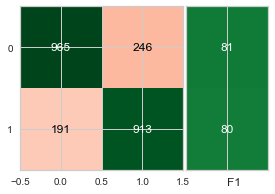

In [42]:
# Plot confusion matrix from Cross-Validation with F1

from museotoolbox.ai import SuperLearner
from museotoolbox.cross_validation import RandomStratifiedKFold
from museotoolbox.charts import PlotConfusionMatrix

# Create CV
RSKF = RandomStratifiedKFold(n_splits=2,
                random_state=12,verbose=False)

#start learning
SL = SuperLearner(classifier = model, param_grid = dict(n_estimators=[10,50]))
SL.fit(x_s_res_train, y_s_res_train, cv = RSKF)

# Get kappa from each fold
for stats in SL.get_stats_from_cv(confusion_matrix = False, kappa = True):
    print(stats['kappa'])
    
# Get each confusion matrix from folds
cms = []
for stats in SL.get_stats_from_cv(confusion_matrix = True):
    cms.append(stats['confusion_matrix'])
    print(stats['confusion_matrix'])
# Plot confusion matrix

meanCM = np.mean(cms,axis = 0).astype(np.int16)
pltCM = PlotConfusionMatrix(meanCM.T) # Translate for Y = prediction and X = truth
pltCM.add_text()
pltCM.add_f1()
pltCM.color_diagonal()
